# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
# !pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [2]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [3]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # this is an important module to get imported which may even cause issues while reading the data if not used
import seaborn as sns # for data visualization
import tensorflow as tf
import keras
import os
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model #sequential api for sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Activation
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop,Adam,SGD #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import  ReduceLROnPlateau # To adjust the learning rate dynamically based on the performance
from tensorflow.keras.callbacks import   TensorBoard # To monitor and visualize training progress.
from tensorflow.keras.callbacks import ModelCheckpoint  #to save the best model
from tensorflow.keras import losses, optimizers
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.image import random_brightness, random_contrast, random_flip_left_right, random_flip_up_down

## Loading the dataset

In [4]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path='/content/drive/MyDrive/courses_AI_ML/Computer_vision /project_CV/Labels.csv'
labels_df=pd.read_csv(path)


In [6]:
labels_df.Label.value_counts().values

array([654, 611, 516, 496, 475, 390, 385, 287, 263, 231, 221, 221])

In [7]:
path1='/content/drive/MyDrive/courses_AI_ML/Computer_vision /project_CV/images.npy'
images=np.load(path1)

## Data Overview

### Understand the shape of the dataset

In [8]:
images.shape

(4750, 128, 128, 3)

We have 4750 images, each with a size of (128, 128) pixels and 3 color BGR

In [9]:
# Check that the number of images matches the number of labels
assert len(images) == len(labels_df), "Number of images and labels do not match!"

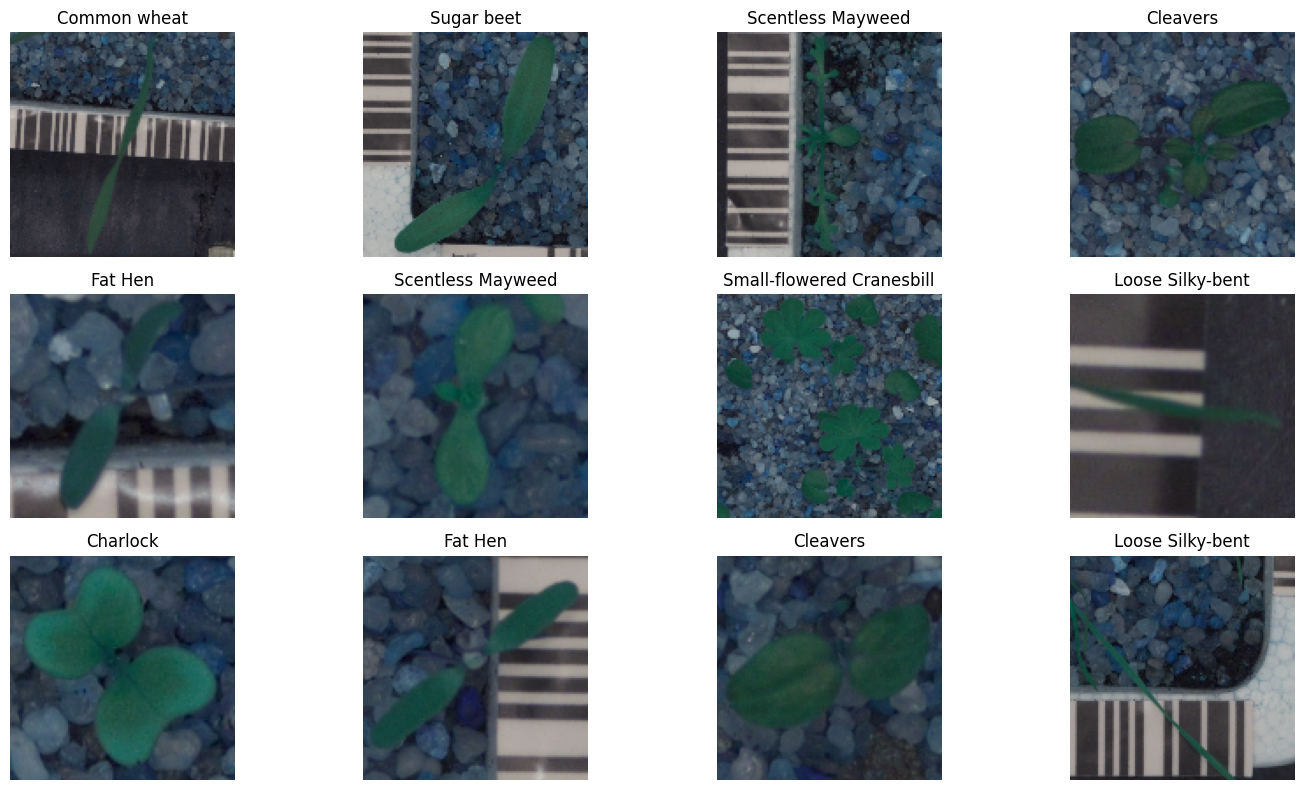

In [10]:
# Function to plot randomly selected images with labels in a 4xN grid
def plot_images_labels(images, labels, num_images=12, images_per_row=4):
    total_images = len(images)  # Total number of images available

    # Randomly pick indices
    random_indices = np.random.choice(total_images, num_images, replace=False)

    rows = (num_images // images_per_row) + (num_images % images_per_row > 0)  # Calculate the number of rows needed
    plt.figure(figsize=(15, 8))

    for i, idx in enumerate(random_indices):
        plt.subplot(rows, images_per_row, i + 1)  # Create subplot for each image
        plt.imshow(images[idx])  # Display the randomly selected image
        plt.title(labels.iloc[idx, 0])  # Assuming the label is in the first column
        plt.axis('off')  # Hide the axis

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function to plot 12 randomly selected images, 4 images per row
plot_images_labels(images, labels_df, num_images=12, images_per_row=4)


In [11]:
labels = labels_df['Label'].values
labels

array(['Small-flowered Cranesbill', 'Small-flowered Cranesbill',
       'Small-flowered Cranesbill', ..., 'Loose Silky-bent',
       'Loose Silky-bent', 'Loose Silky-bent'], dtype=object)

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

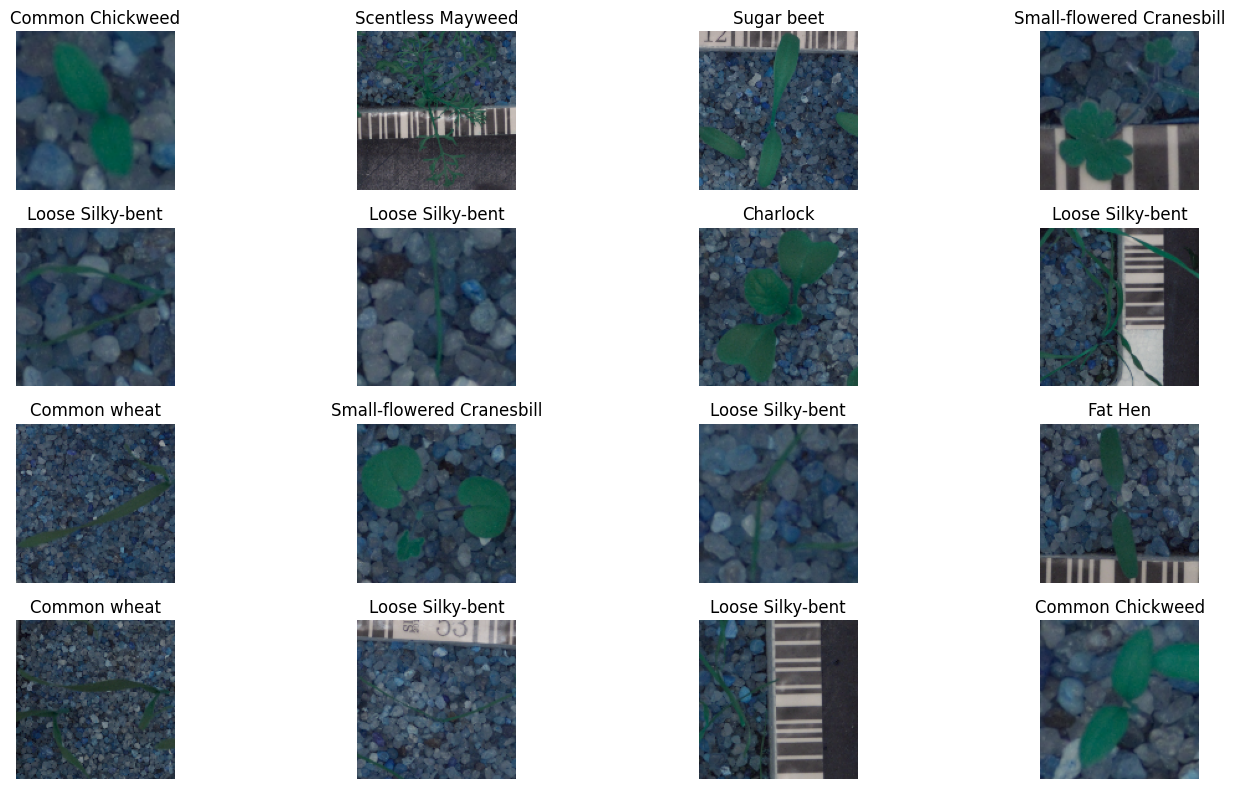

In [12]:
plot_images_labels(images, labels_df, num_images=16, images_per_row=4)

- The leaves of the plant seedlings are all green.
- Despite having different leaf shapes and sizes, these plants still have a similar overall appearance, which might make it challenging for the model to distinguish between them.

Text(0.5, 1.0, 'Distribution of Labels')

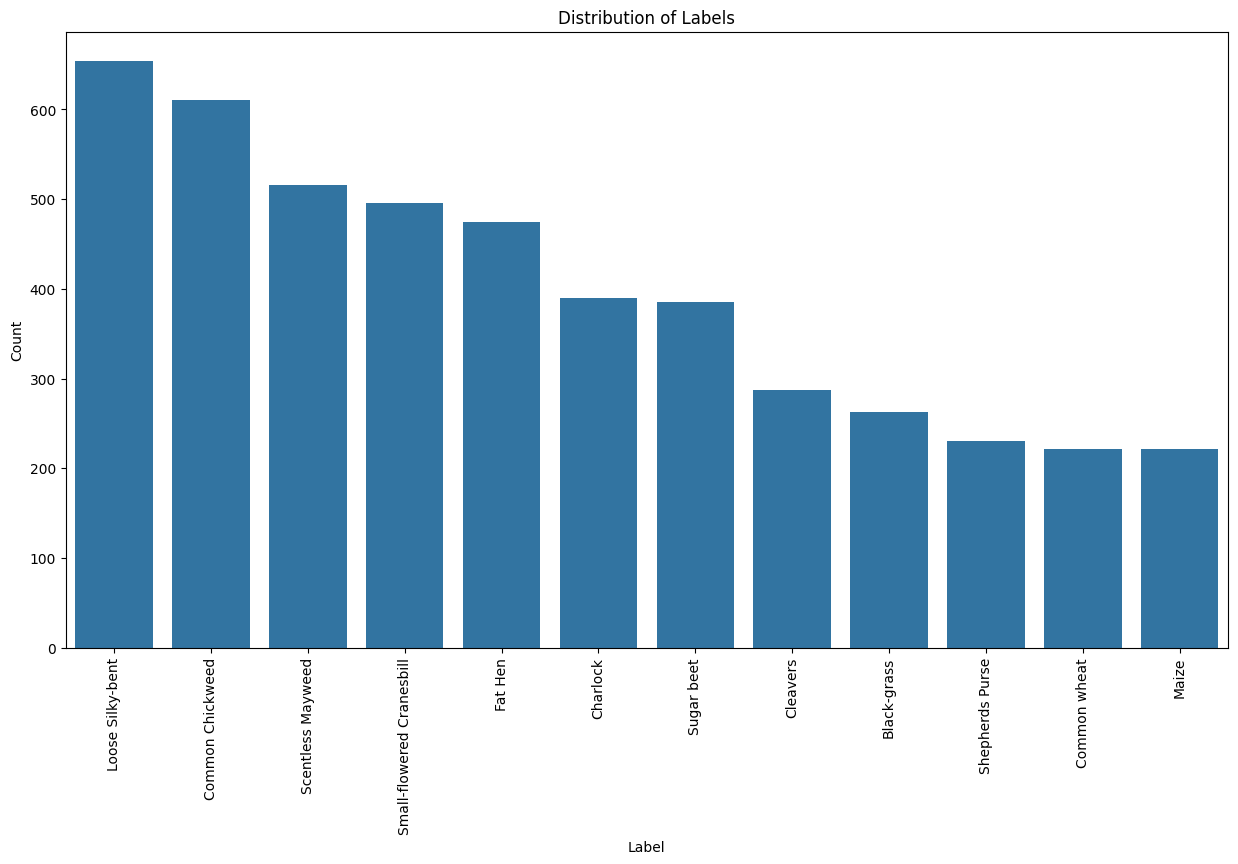

In [13]:
# Calculate the value counts
counts = labels_df['Label'].value_counts()

# Create a bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x=counts.index, y=counts.values)  # counts.index for labels and counts.values for values
plt.xticks(rotation=90)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")

the labels are imbalanced

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [14]:
images_rgb = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images])

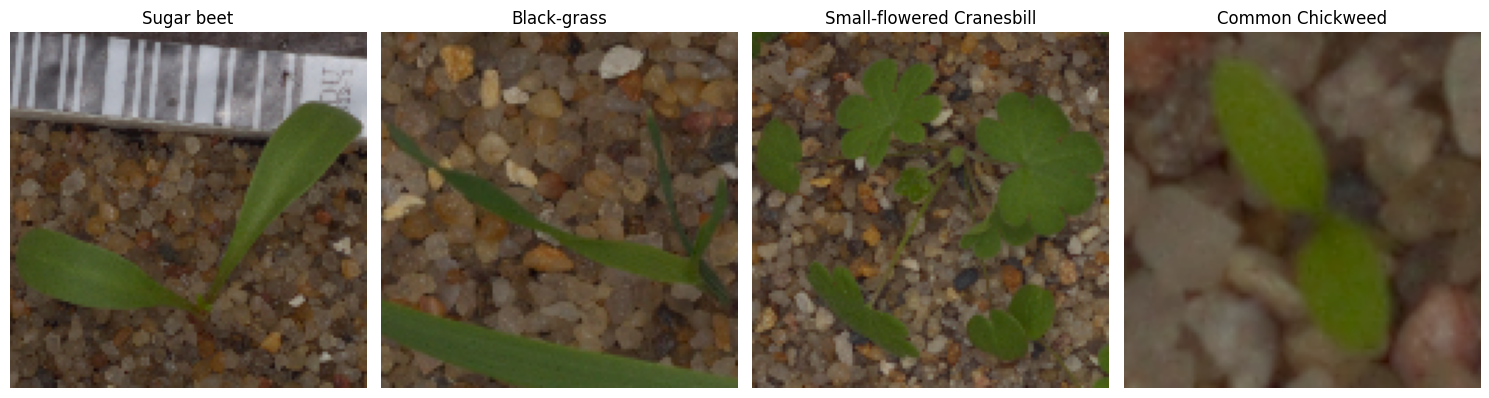

In [15]:
plot_images_labels(images_rgb, labels_df,num_images=4)

the images appears more clear now

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [16]:
# Resize all images to 64x64
dimentions=(64,64)
images_resized = np.array([cv2.resize(image, dimentions, interpolation=cv2.INTER_LINEAR) for image in images_rgb])

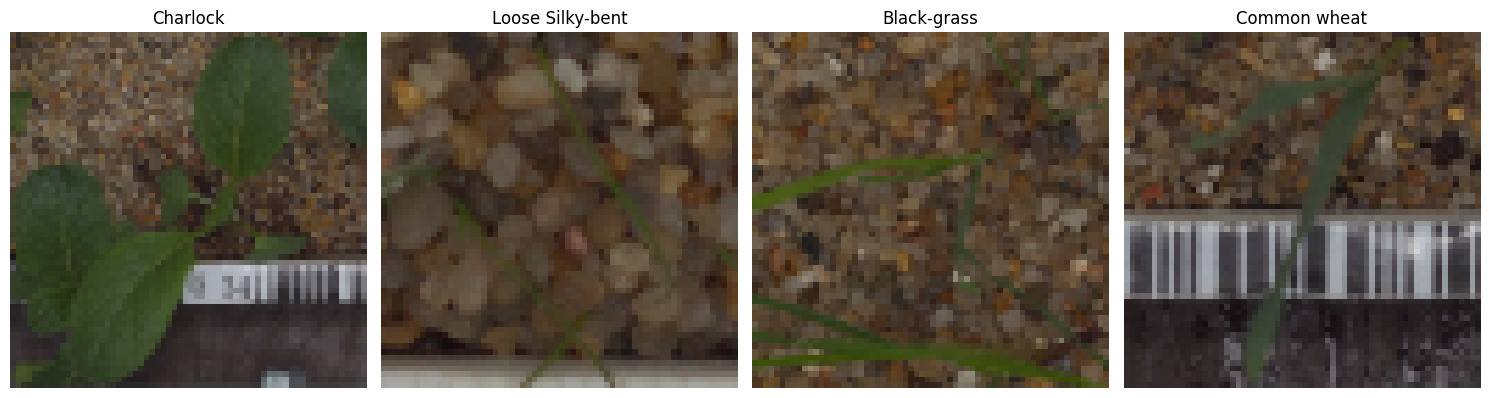

In [17]:
plot_images_labels(images_resized, labels_df,num_images=4)

the images at this stage have less quality

### Data Preparation for Modeling

#### Encode the target labels

In [18]:
from sklearn.preprocessing import LabelBinarizer

In [19]:
# Ensure labels are strings and strip extra spaces if necessary
labels = labels_df['Label'].astype(str).str.strip().values

# Initialize and fit LabelBinarizer
label_binarizer = LabelBinarizer()
one_hot_encoded_labels = label_binarizer.fit_transform(labels)

**Split the dataset**

In [20]:
# we have to choose   :  the simple method split from sklearn or  tf.data.Dataset API from tensorflow split
#from sklearn.model_selection import train_test_split
#img_temp, img_test, label_temp, label_test = train_test_split(images_resized, labels, test_size=0.2,shuffle=True,stratify=labels, random_state=1)

In [21]:
# Create TensorFlow dataset from images and labels
dataset = tf.data.Dataset.from_tensor_slices((images_resized, one_hot_encoded_labels))
dataset = dataset.shuffle(buffer_size=len(images_resized), seed=42)

In [22]:
# Determine sizes for train, validation, and test splits
train_size = int(0.8 * len(images_resized))
val_size = int(0.1 * len(images_resized))
test_size = len(images_resized) - train_size - val_size

In [23]:
# Split the dataset
train_dataset1 = dataset.take(train_size) # we give the train dataset a unuque name for data augmentation pupose to avoid batching it twice
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

#### Data Normalization

In [24]:
# function for normalizing images
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Scale images to [0, 1] range
    return image, label

 Batch and prefetch the dataset for improved efficiency during model training

In [25]:
# Apply normalization and batching
batch_size = 32
train_dataset = train_dataset1.map(normalize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(normalize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#### Final check

In [26]:
#Check dataset shapes
for images_batch, labels_batch in train_dataset.take(1):
    print('Train image batch shape:', images_batch.shape)
    print('Train label batch shape:', labels_batch.shape)

for images_batch, labels_batch in val_dataset.take(1):
    print('Validation image batch shape:', images_batch.shape)
    print('Validation label batch shape:', labels_batch.shape)

for images_batch, labels_batch in test_dataset.take(1):
    print('Test image batch shape:', images_batch.shape)
    print('Test label batch shape:', labels_batch.shape)


Train image batch shape: (32, 64, 64, 3)
Train label batch shape: (32, 12)
Validation image batch shape: (32, 64, 64, 3)
Validation label batch shape: (32, 12)
Test image batch shape: (32, 64, 64, 3)
Test label batch shape: (32, 12)


The shapes and labels of our batches look correct, the shape of a single image is ( 64, 64, 3) , each batch have 32 image , and label shape has (32, 12) with 12 lables

**Note** : So tensorFlow will automatically process each batch when we feed our data into our model

**Conclusion:**

- We developed a TensorFlow dataset pipeline.
- One-hot encoding are applied before building the pipeline
- normalization are implemented within the pipeline.

**Note**: Our approach appears to be efficient and effective.

Function utile

In [27]:
def plot_confusion_matrix(model, test_dataset):
    # Predict on the test dataset
    y_pred = model.predict(test_dataset)

    # Obtain the true labels from the test dataset
    y_test_all = []
    for images, labels in test_dataset:
        y_test_all.append(labels.numpy())

    # Convert list of label batches to a single array
    y_test_all = np.concatenate(y_test_all, axis=0)

    # Convert one-hot encoded labels to categorical values
    y_test_arg = np.argmax(y_test_all, axis=1)

    # Convert y_pred to categorical values
    y_pred_arg = np.argmax(y_pred, axis=1)

    # Compute confusion matrix
    conf_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg).numpy()

    # Normalize the confusion matrix
    normalized_conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

    # Plot confusion matrix with enhanced diagonal
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, linewidths=.4, fmt="d", cmap='Blues', cbar=False, annot_kws={"size": 15})

    # Overlay the normalized diagonal
    for i in range(conf_matrix.shape[0]):
        plt.text(i + 0.5, i + 0.5, f'{normalized_conf_matrix[i, i]:.2f}',
                 color='red', ha='center', va='center', fontweight='bold', fontsize=15)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix with Enhanced Diagonal')
    plt.show()

In [28]:
# Custom F1 score metric
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * p * r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

## Model Building

In [29]:
import warnings

# Ignore all types of warnings
warnings.filterwarnings("ignore")

### Model 1

In [30]:
# Clearing backend
from keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [31]:
# initialize the model
model1=Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(64, (3,3), activation='relu', padding='same',input_shape= (64,64,3))) #
# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D(pool_size=(2,2),padding='same'))

# adding the second conv layer with 32 filters and kernel size 3x3 and padding 'same
model1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
# adding max pooling to finish the second conv block
model1.add(MaxPooling2D(pool_size=(2,2),padding='same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with ? neurons
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))

# Adding a dropout layer to prevent overfitting
model1.add(Dense(12, activation='softmax'))

# compile the model , the first optimizer is adam
#model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', f1_score])

# Generating the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,079,692 (4.12 MB)

 Trainable params: 1,079,692 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

the total parameters that should be trained is 1,079,692

---



In [32]:
import time
# Start counting time before training
start_time = time.time()

# Train the model on the batched dataset
history1 = model1.fit(
    train_dataset,             # Batched training dataset
    validation_data=val_dataset,  # Batched validation dataset
    epochs=50 ,                 # Number of epochs
    verbose=2
)

# End counting time after training
end_time = time.time()
# Calculate the total time taken
training_time1 = end_time - start_time

Epoch 1/50
119/119 - 9s - 77ms/step - accuracy: 0.1903 - f1_score: 0.0018 - loss: 2.3082 - val_accuracy: 0.3516 - val_f1_score: 0.0487 - val_loss: 1.8915
Epoch 2/50
119/119 - 1s - 5ms/step - accuracy: 0.4008 - f1_score: 0.0982 - loss: 1.6887 - val_accuracy: 0.4779 - val_f1_score: 0.1888 - val_loss: 1.4101
Epoch 3/50
119/119 - 1s - 5ms/step - accuracy: 0.5411 - f1_score: 0.2474 - loss: 1.3206 - val_accuracy: 0.6000 - val_f1_score: 0.3839 - val_loss: 1.1373
Epoch 4/50
119/119 - 1s - 5ms/step - accuracy: 0.6063 - f1_score: 0.3651 - loss: 1.1120 - val_accuracy: 0.6568 - val_f1_score: 0.4164 - val_loss: 0.9686
Epoch 5/50
119/119 - 1s - 5ms/step - accuracy: 0.6663 - f1_score: 0.4326 - loss: 0.9769 - val_accuracy: 0.6947 - val_f1_score: 0.5039 - val_loss: 0.8866
Epoch 6/50
119/119 - 1s - 5ms/step - accuracy: 0.6811 - f1_score: 0.4682 - loss: 0.9157 - val_accuracy: 0.7726 - val_f1_score: 0.5675 - val_loss: 0.7132
Epoch 7/50
119/119 - 1s - 5ms/step - accuracy: 0.6976 - f1_score: 0.5021 - loss: 

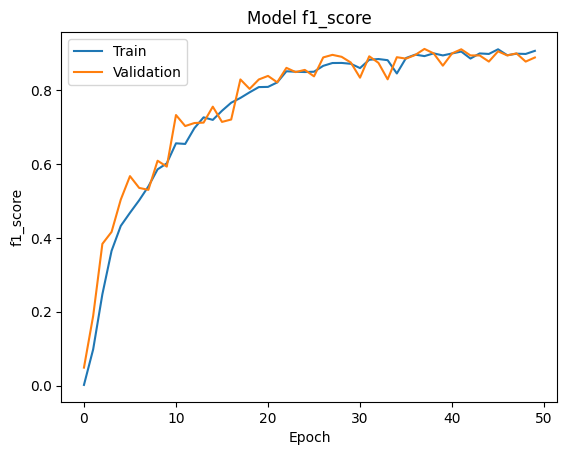

In [33]:
plt.plot(history1.history['f1_score'])
plt.plot(history1.history['val_f1_score'])
plt.title('Model f1_score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

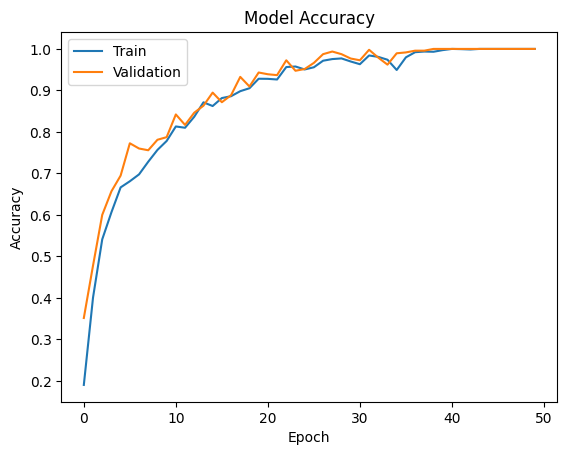

In [34]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

our model is  performing well specially on validation set wish may means is overfiting but we will make sure after evalution on the test set , let's add same complexity to our architecture

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


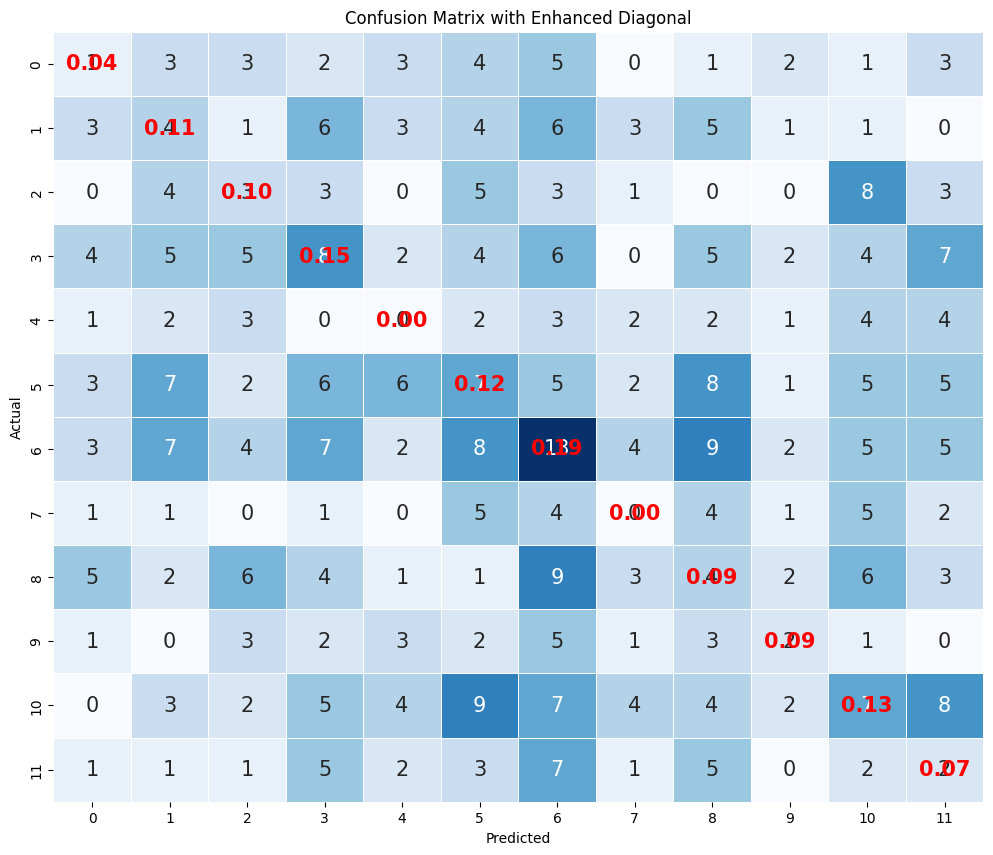

In [35]:
plot_confusion_matrix(model1, test_dataset)

The model is still having trouble classifying the sibling images. Let's keep working on it.

### Model 2

We added another convolutional layer with the same parameters but increased the number of convolutional filters

In [36]:
# Clearing backend
from keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [37]:
# initialize the model
model2=Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model2.add(Conv2D(128, (3,3), activation='relu', padding='same',input_shape= (64,64,3))) #
# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D(pool_size=(2,2),padding='same'))

# adding the second conv layer with 32 filters and kernel size 3x3 and padding 'same
model2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
# adding max pooling to finish the second conv block
model2.add(MaxPooling2D(pool_size=(2,2),padding='same'))

# adding the therd conv layer with 32 filters and kernel size 3x3 and padding 'same
model2.add(Conv2D(32, (3,3), activation='relu', padding='same'))
# adding max pooling to finish the therd conv block
model2.add(MaxPooling2D(pool_size=(2,2),padding='same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with ? neurons
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))

# Adding the output layers with softmax activation function
model2.add(Dense(12, activation='softmax'))

# compile the model , the first optimizer is adam
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy',f1_score])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 368,844 (1.41 MB)

 Trainable params: 368,844 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Definitely, the model becomes more complex with over than 3 million parameters to train

In [38]:
# Start counting time before training
start_time = time.time()
history2 = model2.fit(
    train_dataset,             # Batched training dataset
    validation_data=val_dataset,  # Batched validation dataset
    epochs=50 ,                 # Number of epochs
    verbose=2
)

# End counting time after training
end_time = time.time()
# Calculate the total time taken
training_time2 = end_time - start_time

Epoch 1/50
119/119 - 8s - 71ms/step - accuracy: 0.1303 - f1_score: 0.0000e+00 - loss: 2.4335 - val_accuracy: 0.1937 - val_f1_score: 0.0000e+00 - val_loss: 2.3990
Epoch 2/50
119/119 - 1s - 9ms/step - accuracy: 0.2337 - f1_score: 0.0132 - loss: 2.2473 - val_accuracy: 0.3895 - val_f1_score: 0.1047 - val_loss: 1.7699
Epoch 3/50
119/119 - 1s - 9ms/step - accuracy: 0.4153 - f1_score: 0.1139 - loss: 1.6245 - val_accuracy: 0.4505 - val_f1_score: 0.1485 - val_loss: 1.5833
Epoch 4/50
119/119 - 1s - 9ms/step - accuracy: 0.4926 - f1_score: 0.1806 - loss: 1.4107 - val_accuracy: 0.5368 - val_f1_score: 0.1805 - val_loss: 1.2397
Epoch 5/50
119/119 - 1s - 9ms/step - accuracy: 0.6084 - f1_score: 0.3296 - loss: 1.1355 - val_accuracy: 0.5895 - val_f1_score: 0.3916 - val_loss: 1.0846
Epoch 6/50
119/119 - 1s - 9ms/step - accuracy: 0.6571 - f1_score: 0.4321 - loss: 0.9795 - val_accuracy: 0.6884 - val_f1_score: 0.4809 - val_loss: 0.8835
Epoch 7/50
119/119 - 1s - 9ms/step - accuracy: 0.6950 - f1_score: 0.4925 

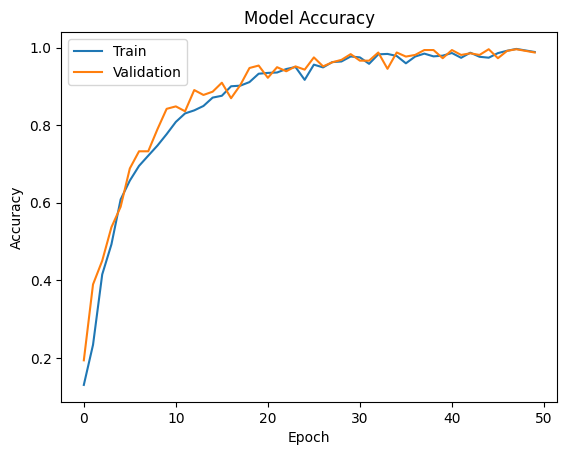

In [39]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

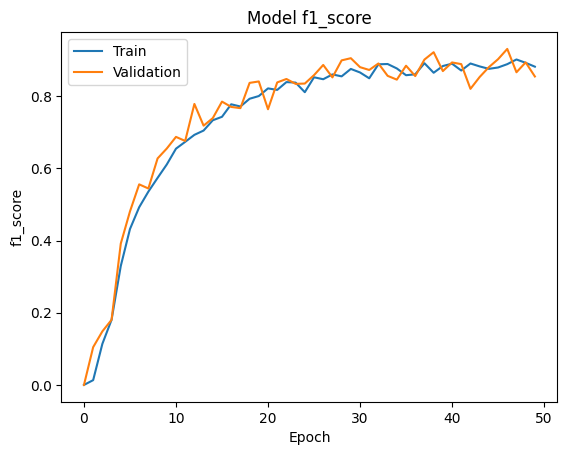

In [40]:
plt.plot(history2.history['f1_score'])
plt.plot(history2.history['val_f1_score'])
plt.title('Model f1_score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


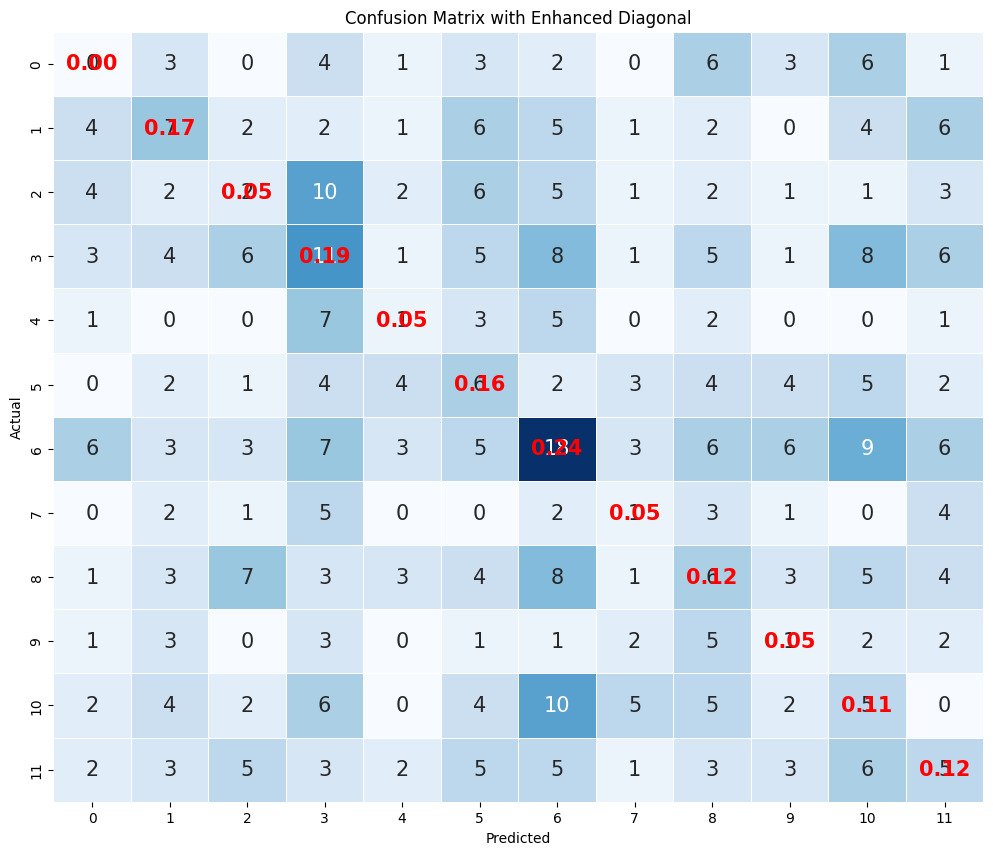

In [41]:
plot_confusion_matrix(model2, test_dataset)

the confusion still not improved , same images never recognized by the model

This model's performance was inferior to the previous one, suggesting that we may not need to increase the complexity of the architecture. For example, two convolutional blocks might suffice

### Model 3

Let's add batch normalization layers and dropout techniques and desactivete one convolutional layer

In [42]:
# Clearing backend
from keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# initialize the model
model3=Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
#model2.add(Conv2D(128, (3,3), activation='relu', padding='same',input_shape= (64,64,3))) #
#model2.add(MaxPooling2D(pool_size=(2,2),padding='same'))
#model2.add(Dropout(0.2))
#model2.add(BatchNormalization())

# adding the first conv layer with 32 filters and kernel size 3x3 and padding 'same
model3.add(Conv2D(64, (3,3), activation='relu', padding='same',input_shape= (64,64,3)))
# adding max pooling to finish the second conv block
model3.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model3.add(Dropout(0.2))
#model2.add(BatchNormalization())

# adding the second conv layer with 32 filters and kernel size 3x3 and padding 'same
model3.add(Conv2D(32, (3,3), activation='relu', padding='same'))
# adding max pooling to finish the therd conv block
model3.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model3.add(Dropout(0.2))
#model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model3.add(Flatten())

# Adding a fully connected dense layer with ? neurons
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
#model2.add(BatchNormalization())
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
#model2.add(BatchNormalization())
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.1))
#model2.add(BatchNormalization())

# Adding the output layer
model3.add(Dense(12, activation='softmax'))

# compile the model , the first optimizer is adam
model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', f1_score])

# Generating the summary of the model
model3.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,079,692 (4.12 MB)

 Trainable params: 1,079,692 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Start counting time before training
start_time = time.time()

history3 = model3.fit(
    train_dataset,             # Batched training dataset
    validation_data=val_dataset,  # Batched validation dataset
    epochs=50 ,                 # Number of epochs
    verbose=2
)

# End counting time after training
end_time = time.time()
# Calculate the total time taken
training_time3 = end_time - start_time

Epoch 1/50
119/119 - 9s - 77ms/step - accuracy: 0.1245 - f1_score: 0.0000e+00 - loss: 2.4475 - val_accuracy: 0.1368 - val_f1_score: 0.0000e+00 - val_loss: 2.4460
Epoch 2/50
119/119 - 1s - 6ms/step - accuracy: 0.1676 - f1_score: 7.2529e-04 - loss: 2.3958 - val_accuracy: 0.2842 - val_f1_score: 0.0028 - val_loss: 2.1893
Epoch 3/50
119/119 - 1s - 6ms/step - accuracy: 0.3361 - f1_score: 0.0558 - loss: 1.9542 - val_accuracy: 0.4484 - val_f1_score: 0.1289 - val_loss: 1.6387
Epoch 4/50
119/119 - 1s - 6ms/step - accuracy: 0.4118 - f1_score: 0.1337 - loss: 1.6745 - val_accuracy: 0.5116 - val_f1_score: 0.1801 - val_loss: 1.3840
Epoch 5/50
119/119 - 1s - 6ms/step - accuracy: 0.4689 - f1_score: 0.1970 - loss: 1.4892 - val_accuracy: 0.5537 - val_f1_score: 0.2350 - val_loss: 1.2529
Epoch 6/50
119/119 - 1s - 6ms/step - accuracy: 0.5274 - f1_score: 0.2544 - loss: 1.3491 - val_accuracy: 0.6421 - val_f1_score: 0.3389 - val_loss: 1.0352
Epoch 7/50
119/119 - 1s - 6ms/step - accuracy: 0.5642 - f1_score: 0.2

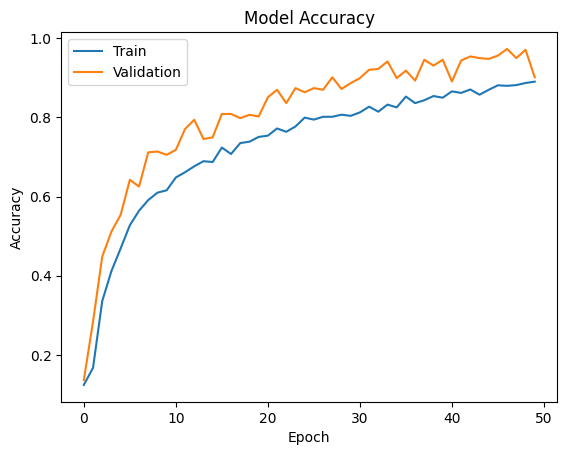

In [44]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

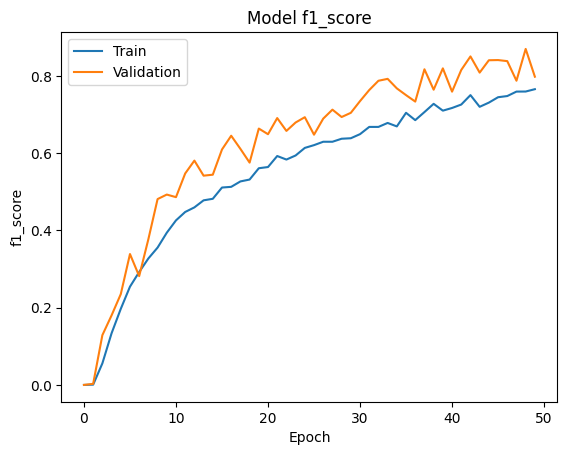

In [45]:
plt.plot(history3.history['f1_score'])
plt.plot(history3.history['val_f1_score'])
plt.title('Model f1_score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


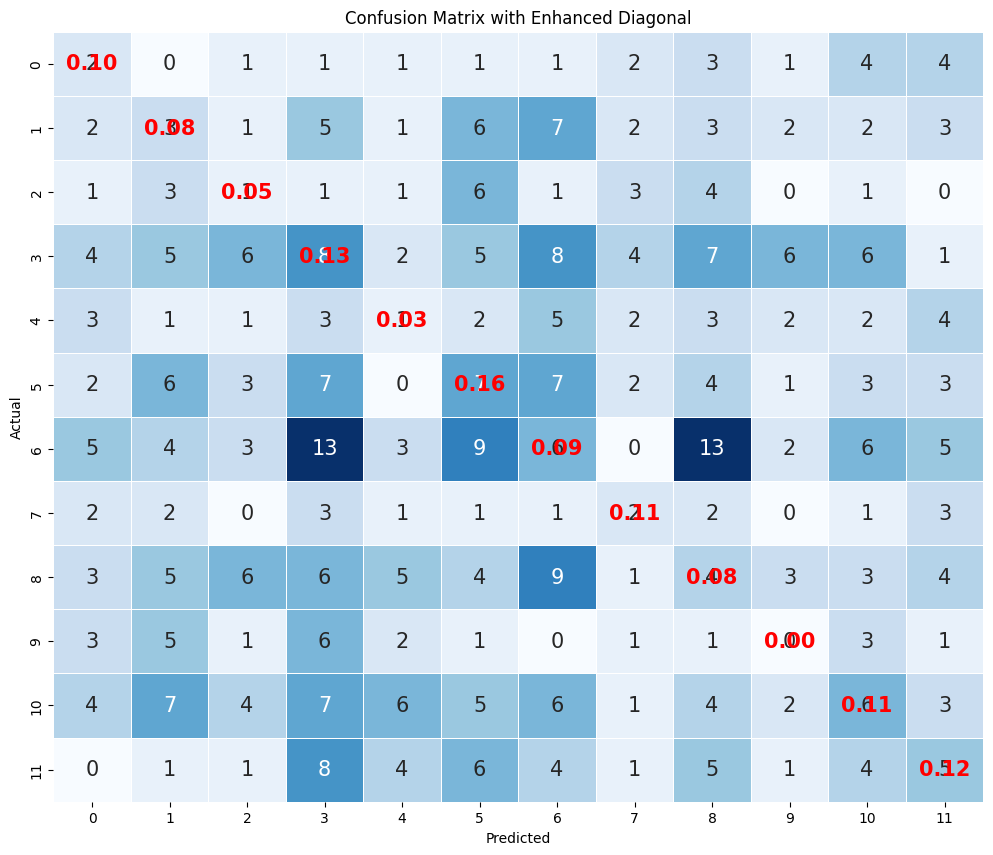

In [46]:
plot_confusion_matrix(model3, test_dataset)

we noticed that increasing the number of epochs led to model instability. Batch normalization contributed to fluctuations in performance.

**Note** : the first model remains the best architecture.

### Model 4

Let's test this model with callback methods, excluding dropout and batch normalization

In [47]:
# Clearing backend
from keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# initialize the model
model4=Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
#model3.add(Conv2D(128, (3,3), activation='relu', padding='same',input_shape= (64,64,3))) #
# Adding max pooling to reduce the size of output of first conv layer
#model3.add(MaxPooling2D(pool_size=(2,2),padding='same'))

# adding the first conv layer with 32 filters and kernel size 3x3 and padding 'same
model4.add(Conv2D(64, (3,3), activation='relu', padding='same',input_shape= (64,64,3)))
# adding max pooling to finish the second conv block
model4.add(MaxPooling2D(pool_size=(2,2),padding='same'))
#model3.add(BatchNormalization())
model4.add(Dropout(0.1))

# adding the second conv block with 32 filters and kernel size 3x3 and padding 'same
model4.add(Conv2D(32, (3,3), activation='relu', padding='same'))
# adding max pooling to finish the therd conv block
model4.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model4.add(Dropout(0.1))
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model4.add(Flatten())

# Adding a fully connected dense layer with ? neurons
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(32, activation='relu'))

# Adding the output layer
model4.add(Dense(12, activation='softmax'))

# compile the model , the first optimizer is adam
model4.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy',f1_score])

#EarlyStopping: To halt training early when no improvement is observed.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#ModelCheckpoint: To save the best model during training.
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

#ReduceLROnPlateau: To adjust the learning rate dynamically based on the performance.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

#TensorBoard: To monitor and visualize training progress.
tensorboard = TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

# Generating the summary of the model
model4.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,079,692 (4.12 MB)

 Trainable params: 1,079,692 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Start counting time before training
start_time = time.time()
history4 = model4.fit(
    train_dataset,             # Batched training dataset
    validation_data=val_dataset,  # Batched validation dataset
    epochs=50 ,                 # Number of epochs
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard], # callbacks parameter
    verbose=2
)

# End counting time after training
end_time = time.time()
# Calculate the total time taken
training_time4 = end_time - start_time

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.85732, saving model to best_model.keras
119/119 - 10s - 81ms/step - accuracy: 0.1979 - f1_score: 0.0073 - loss: 2.2912 - val_accuracy: 0.3832 - val_f1_score: 0.0163 - val_loss: 1.8573 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 1.85732 to 1.40737, saving model to best_model.keras
119/119 - 1s - 12ms/step - accuracy: 0.3971 - f1_score: 0.0936 - loss: 1.7416 - val_accuracy: 0.4989 - val_f1_score: 0.1859 - val_loss: 1.4074 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 1.40737 to 1.36381, saving model to best_model.keras
119/119 - 1s - 11ms/step - accuracy: 0.4413 - f1_score: 0.1507 - loss: 1.5520 - val_accuracy: 0.5032 - val_f1_score: 0.1397 - val_loss: 1.3638 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 1.36381 to 1.16176, saving model to best_model.keras
119/119 - 1s - 11ms/step - accuracy: 0.5226 - f1_score: 0.2383 - loss: 1.3549 - val_accuracy: 0.5705 - val_f1_scor

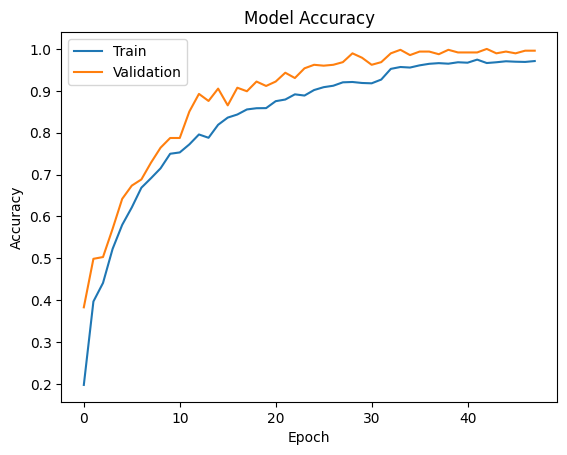

In [49]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

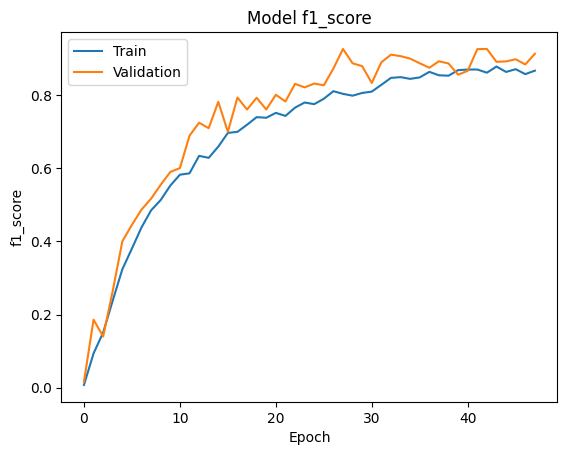

In [50]:
plt.plot(history4.history['f1_score'])
plt.plot(history4.history['val_f1_score'])
plt.title('Model f1_score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

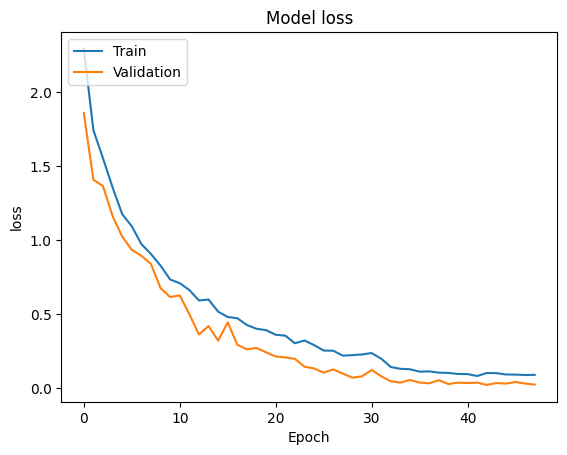

In [51]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


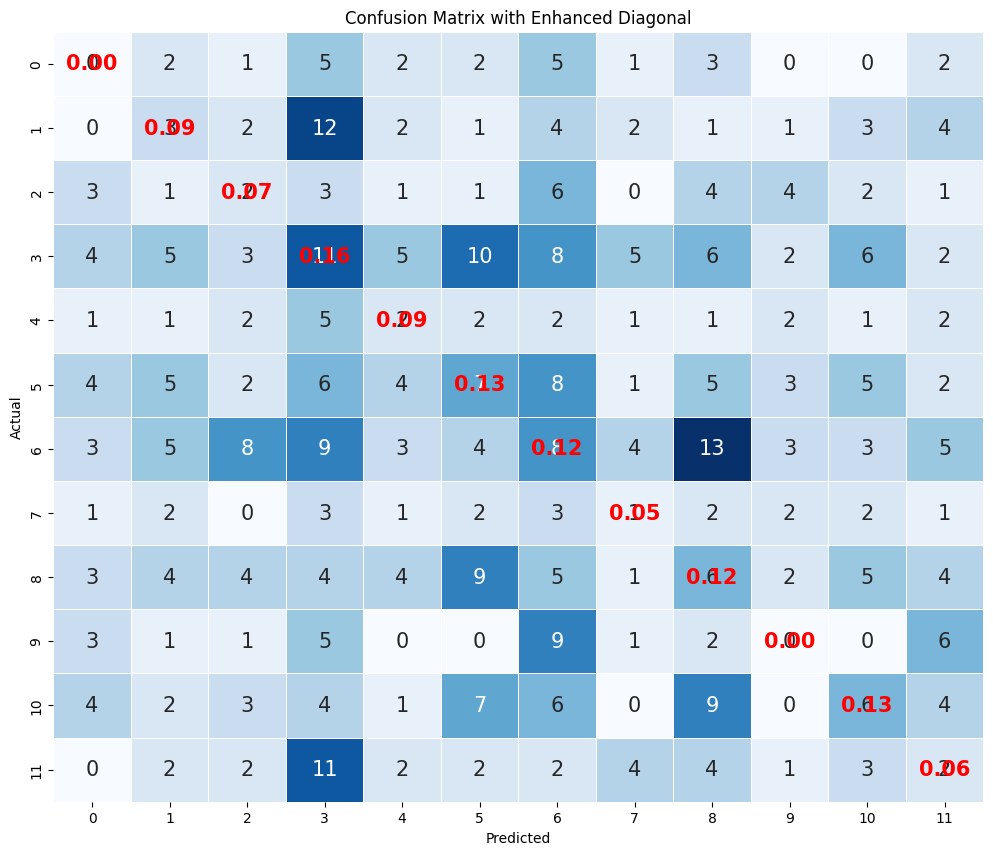

In [52]:
plot_confusion_matrix(model4, test_dataset)

the confusion matrix shows same improvements

To address the fluctuations, we added a dropout layer. While the model's performance improved, it still underperforms compared to the initial model

## Model Performance Improvement

### Data augmentation : model 5

In [53]:
# Define the data augmentation function
def augment_image(image, label):
    image = random_flip_left_right(image)  # Random horizontal flip # tf.image.
    image = random_flip_up_down(image)    # Random vertical flip
    image = random_brightness(image, max_delta=0.2)  # Random brightness adjustment
    image = random_contrast(image, lower=0.8, upper=1.2)  # Random contrast adjustment
    return image, label


# Apply augmentation and normalization to the same training dataset
train_dataset_augmented = (
    train_dataset1            # Start with original training data
    .map(augment_image)       # Apply augmentations
    .map(normalize_image)     # Normalize images after augmentation
    .batch(batch_size)        # Batch after augmenting and normalizing
    .prefetch(tf.data.AUTOTUNE)  # Prefetch for performance
)

In [54]:
# Check the augmented dataset
for images_batch, labels_batch in train_dataset_augmented.take(1):
    print('Augmented train image batch shape:', images_batch.shape)
    print('Train label batch shape:', labels_batch.shape)

for images_batch1, labels_batch1 in val_dataset.take(1):
  print('validation  image batch shape:', images_batch1.shape)
  print('validation label batch shape:', labels_batch1.shape)

Augmented train image batch shape: (32, 64, 64, 3)
Train label batch shape: (32, 12)
validation  image batch shape: (32, 64, 64, 3)
validation label batch shape: (32, 12)


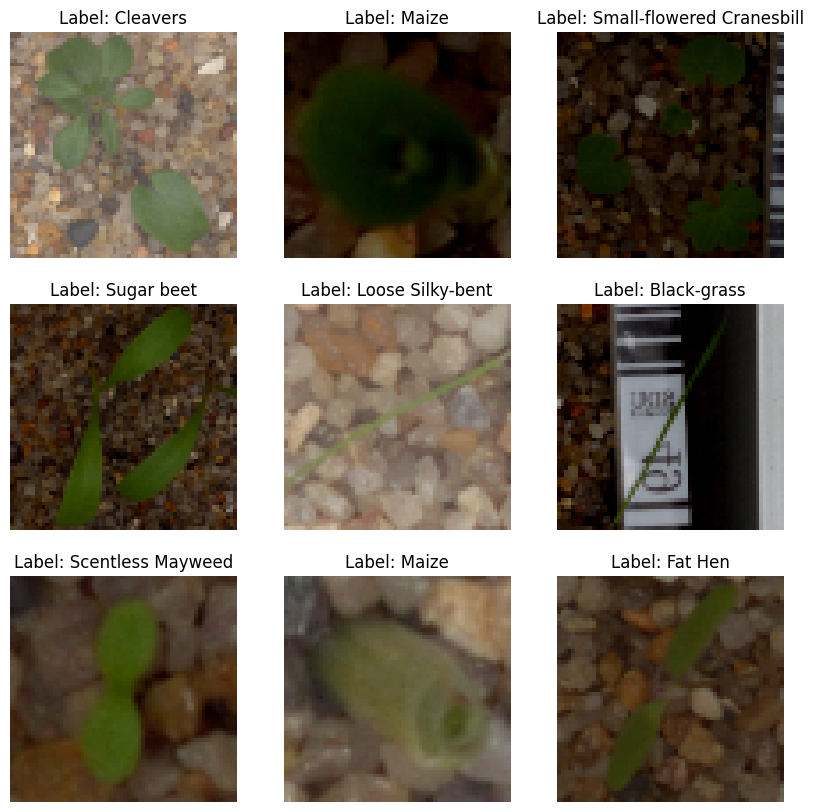

In [55]:
# Function to plot a batch of images and their labels
def plot_random_augmented_images(dataset, label_binarizer, num_images=9):
    # Get a batch of images and labels
    images_batch, labels_batch = next(iter(dataset))

    # Inverse transform the labels back to their original form
    labels_decoded = label_binarizer.inverse_transform(labels_batch.numpy())

    # Randomly select images from the batch
    indices = random.sample(range(images_batch.shape[0]), num_images)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(images_batch[idx].numpy())
        plt.title(f'Label: {labels_decoded[idx]}')
        plt.axis('off')
    plt.show()

# Plot some random images from the augmented training dataset
plot_random_augmented_images(train_dataset_augmented, label_binarizer)


We noted changes in the images following augmentation, including variations in brightness, direction, and color.

In [56]:
# Clearing backend
from keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# initialize the model
model5=Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model5.add(Conv2D(128, (3,3), activation='relu', padding='same',input_shape= (64,64,3))) #
#Adding max pooling to reduce the size of output of first conv layer
model5.add(MaxPooling2D(pool_size=(2,2),padding='same'))
#model5.add(Dropout(0.1))
#model4.add(BatchNormalization())

# adding the second conv layer with 32 filters and kernel size 3x3 and padding 'same
model5.add(Conv2D(64, (3,3), activation='relu', padding='same')) #,input_shape= (64,64,3)
# adding max pooling to finish the second conv block
model5.add(MaxPooling2D(pool_size=(2,2),padding='same'))
#model5.add(Dropout(0.1))


# adding the therd conv layer with 32 filters and kernel size 3x3 and padding 'same
model5.add(Conv2D(16, (3,3), activation='relu', padding='same'))
# adding max pooling to finish the therd conv block
model5.add(MaxPooling2D(pool_size=(2,2),padding='same'))
#model5.add(Dropout(0.1))


# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model5.add(Flatten())

# Adding a fully connected dense layer with ? neurons
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.1))

# Adding the output layer
model5.add(Dense(12, activation='softmax'))
model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228,540 (892.73 KB)

 Trainable params: 228,540 (892.73 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# compile the model , the first optimizer is adam
model5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy',f1_score])

#EarlyStopping: To halt training early when no improvement is observed.
#early_stopping = EarlyStopping(
 #   monitor='val_loss',
  #  patience=10,
   # restore_best_weights=True
#)

#ModelCheckpoint: To save the best model during training.
#model_checkpoint = ModelCheckpoint(
#    'best_model.keras',
#    monitor='val_loss',
#    save_best_only=True,
#    verbose=1
#)

#ReduceLROnPlateau: To adjust the learning rate dynamically based on the performance.
#reduce_lr = ReduceLROnPlateau(
#   monitor='val_loss',
#    factor=0.1,
#    patience=3,
#    verbose=1
#)

#TensorBoard: To monitor and visualize training progress.
#tensorboard = TensorBoard(
#    log_dir='logs',
#    histogram_freq=1,
#    write_graph=True,
#    write_images=True
#)



# Start counting time before training
start_time = time.time()
history5 = model5.fit(
    train_dataset_augmented,             # Batched training dataset
    validation_data=val_dataset,  # Batched validation dataset
    epochs=50 ,                 # Number of epochs
#    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard],
    verbose=2
)

# End counting time after training
end_time = time.time()
# Calculate the total time taken
training_time5 = end_time - start_time

Epoch 1/50
119/119 - 10s - 87ms/step - accuracy: 0.1250 - f1_score: 0.0000e+00 - loss: 2.4460 - val_accuracy: 0.2337 - val_f1_score: 0.0000e+00 - val_loss: 2.3998
Epoch 2/50
119/119 - 1s - 9ms/step - accuracy: 0.2187 - f1_score: 0.0083 - loss: 2.2558 - val_accuracy: 0.3263 - val_f1_score: 0.0181 - val_loss: 1.9271
Epoch 3/50
119/119 - 1s - 9ms/step - accuracy: 0.3482 - f1_score: 0.0763 - loss: 1.8519 - val_accuracy: 0.3832 - val_f1_score: 0.0898 - val_loss: 1.6113
Epoch 4/50
119/119 - 1s - 9ms/step - accuracy: 0.3766 - f1_score: 0.1034 - loss: 1.6929 - val_accuracy: 0.4295 - val_f1_score: 0.1416 - val_loss: 1.5064
Epoch 5/50
119/119 - 1s - 9ms/step - accuracy: 0.4066 - f1_score: 0.1267 - loss: 1.6269 - val_accuracy: 0.5074 - val_f1_score: 0.1274 - val_loss: 1.3944
Epoch 6/50
119/119 - 1s - 9ms/step - accuracy: 0.4305 - f1_score: 0.1449 - loss: 1.5586 - val_accuracy: 0.5053 - val_f1_score: 0.1541 - val_loss: 1.2966
Epoch 7/50
119/119 - 1s - 9ms/step - accuracy: 0.4716 - f1_score: 0.1870

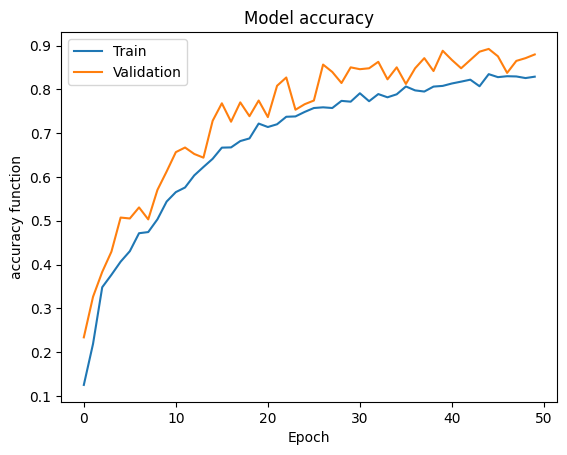

In [58]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy function')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

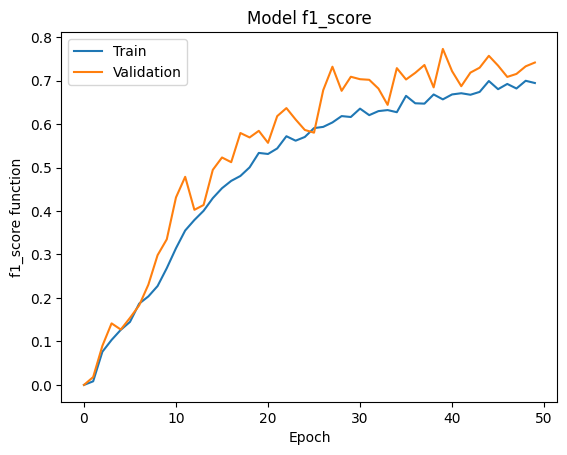

In [59]:
plt.plot(history5.history['f1_score'])
plt.plot(history5.history['val_f1_score'])
plt.title('Model f1_score')
plt.ylabel('f1_score function')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

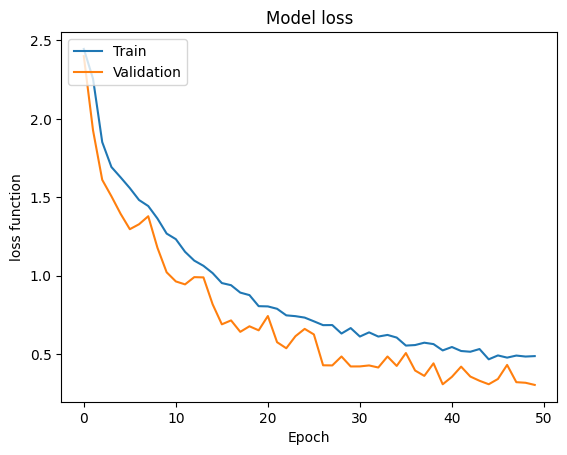

In [60]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss function')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


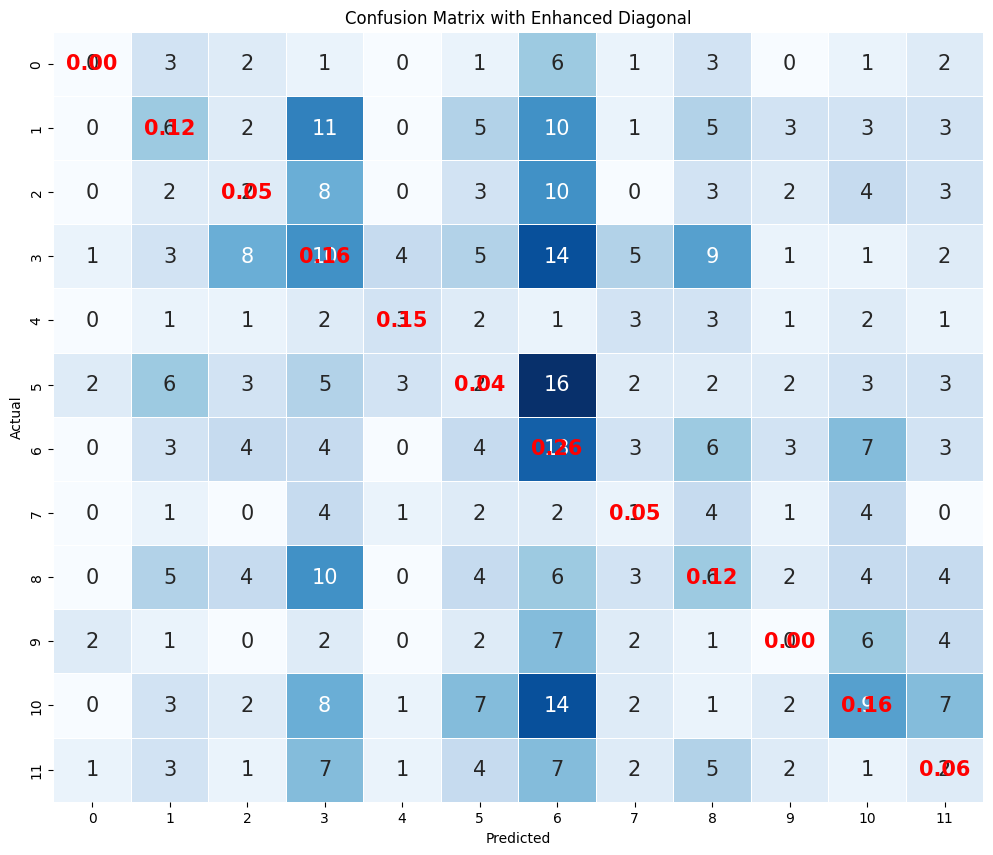

In [61]:
plot_confusion_matrix(model5, test_dataset)

Class 6 remains unrecognized, but Class 9 is new. Other classes are undergoing improvement

Despite data augmentation, the model's performance is below expectations. However, for this dataset, further augmentation might not be necessary. Otherwise, the model learn more features, which usually helps the model generalize better in the long run

Let's evaluate our models on the test set.

### checking the performance on the test_set

In [62]:
# Evaluate the model on the test set

#for idx, mdl in enumerate([model1, model2, model3, model4, model5], start=1):
 #   print(f' Model {idx:^50}')
  #  test_loss, test_accuracy = mdl.evaluate(test_dataset)
   # print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
    #print('\n' + '+=' * 25 + '\n')


In [66]:
# List of model names and model objects
model_names = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5']
models = [model1, model2, model3, model4, model5]

# Create an empty list to store evaluation results
results = []

# Evaluate each model and store the results
for model_name, mdl in zip(model_names, models):
    evaluation = mdl.evaluate(test_dataset, verbose=0)  # verbose=0 to silent output
    test_loss, test_accuracy, test_f1_score = evaluation[0], evaluation[1], evaluation[2]
    results.append({'Model': model_name, 'Test Loss': test_loss, 'Test Accuracy': test_accuracy, 'Test F1 Score': test_f1_score})

# Convert the list of dictionaries to a pandas DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame
print(df_results)


    Model  Test Loss  Test Accuracy  Test F1 Score
0  Model1   0.000328       1.000000       0.938889
1  Model2   0.045062       0.989474       0.857284
2  Model3   0.236613       0.913684       0.807005
3  Model4   0.024455       0.995789       0.921852
4  Model5   0.277953       0.877895       0.735454


- The model 4 with the callback block, dropout, and batch normalization generalizes the best, given the excellent results on the test set (unseen data), with an accuracy of 1 and the smallest loss function value of 0.014. This model has 2 convolutional blocks and 3 fully connected layers.
- The first model also performs well, with an accuracy of almost 1 and a loss function of 0.019.
- The fifth model with augmented images did not perform well on the test set due to the number of features learned. However, this model may perform well in the long run.
- Other models also performed well, but not as well as the fourth and first models.
- For f1_score, model 1 performed best with a value of 0.94, followed by model 4 with an f1 score of 0.92. Other models also performed well but less than the first and fourth.

In [67]:
# Dictionary of models and their corresponding history objects
model_histories = {
    'model1': history1,  #  actual history objects
    'model2': history2,
    'model3': history3,
    'model4': history4,
    'model5': history5,
}

# Dictionary for the running time of each model
training_time= {'model1': training_time1,
              'model2': training_time2,
              'model3': training_time3,
              'model4': training_time4,
              'model5': training_time5
}


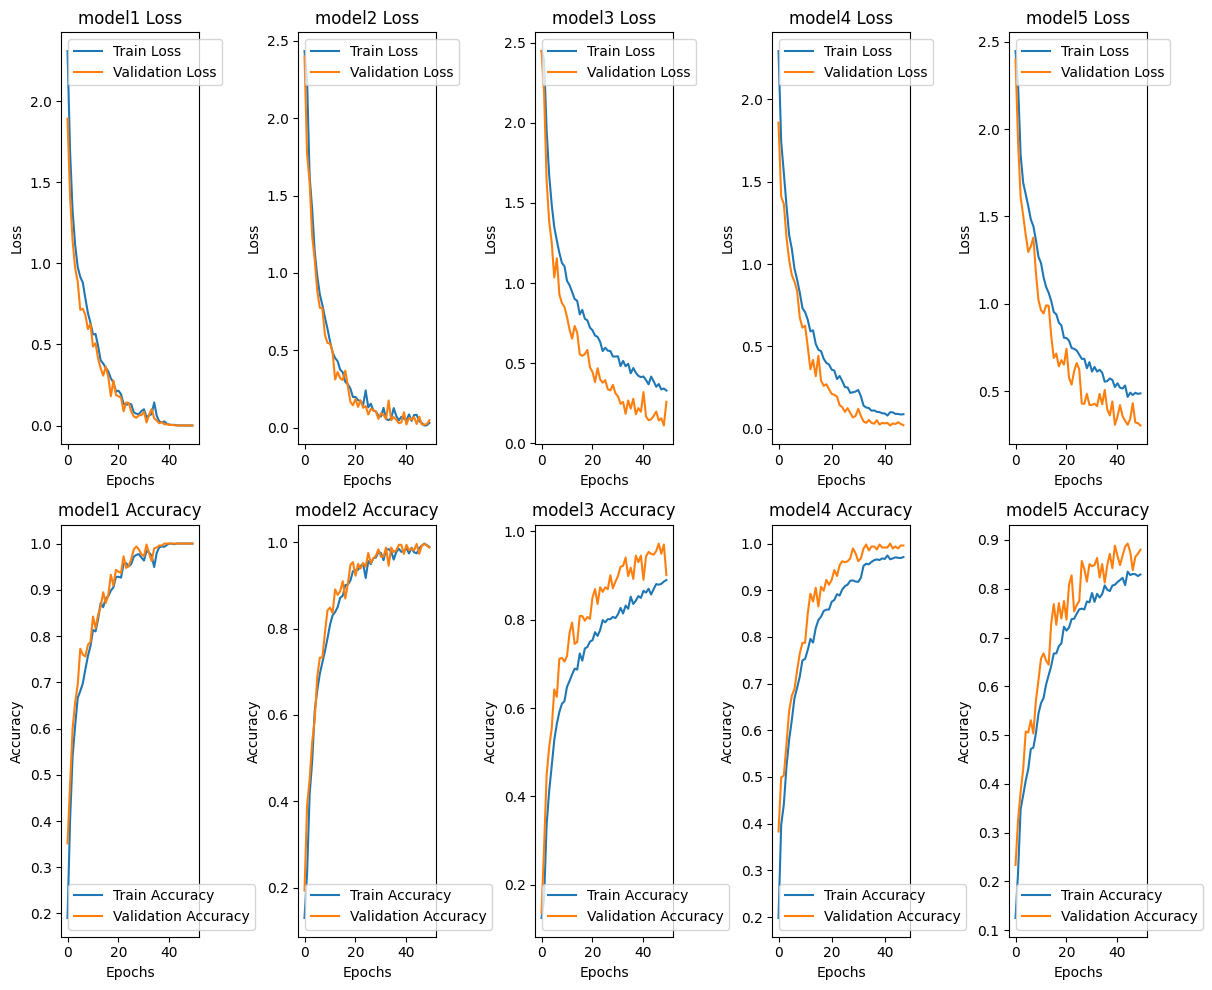

In [68]:
# 1. Plotting Loss and Accuracy
plt.figure(figsize=(12, 10))

for idx, (model_name, history) in enumerate(model_histories.items(), 1):
    # Subplot for Loss
    plt.subplot(2, len(model_histories), idx)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot for Accuracy
    plt.subplot(2, len(model_histories), idx + len(model_histories))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

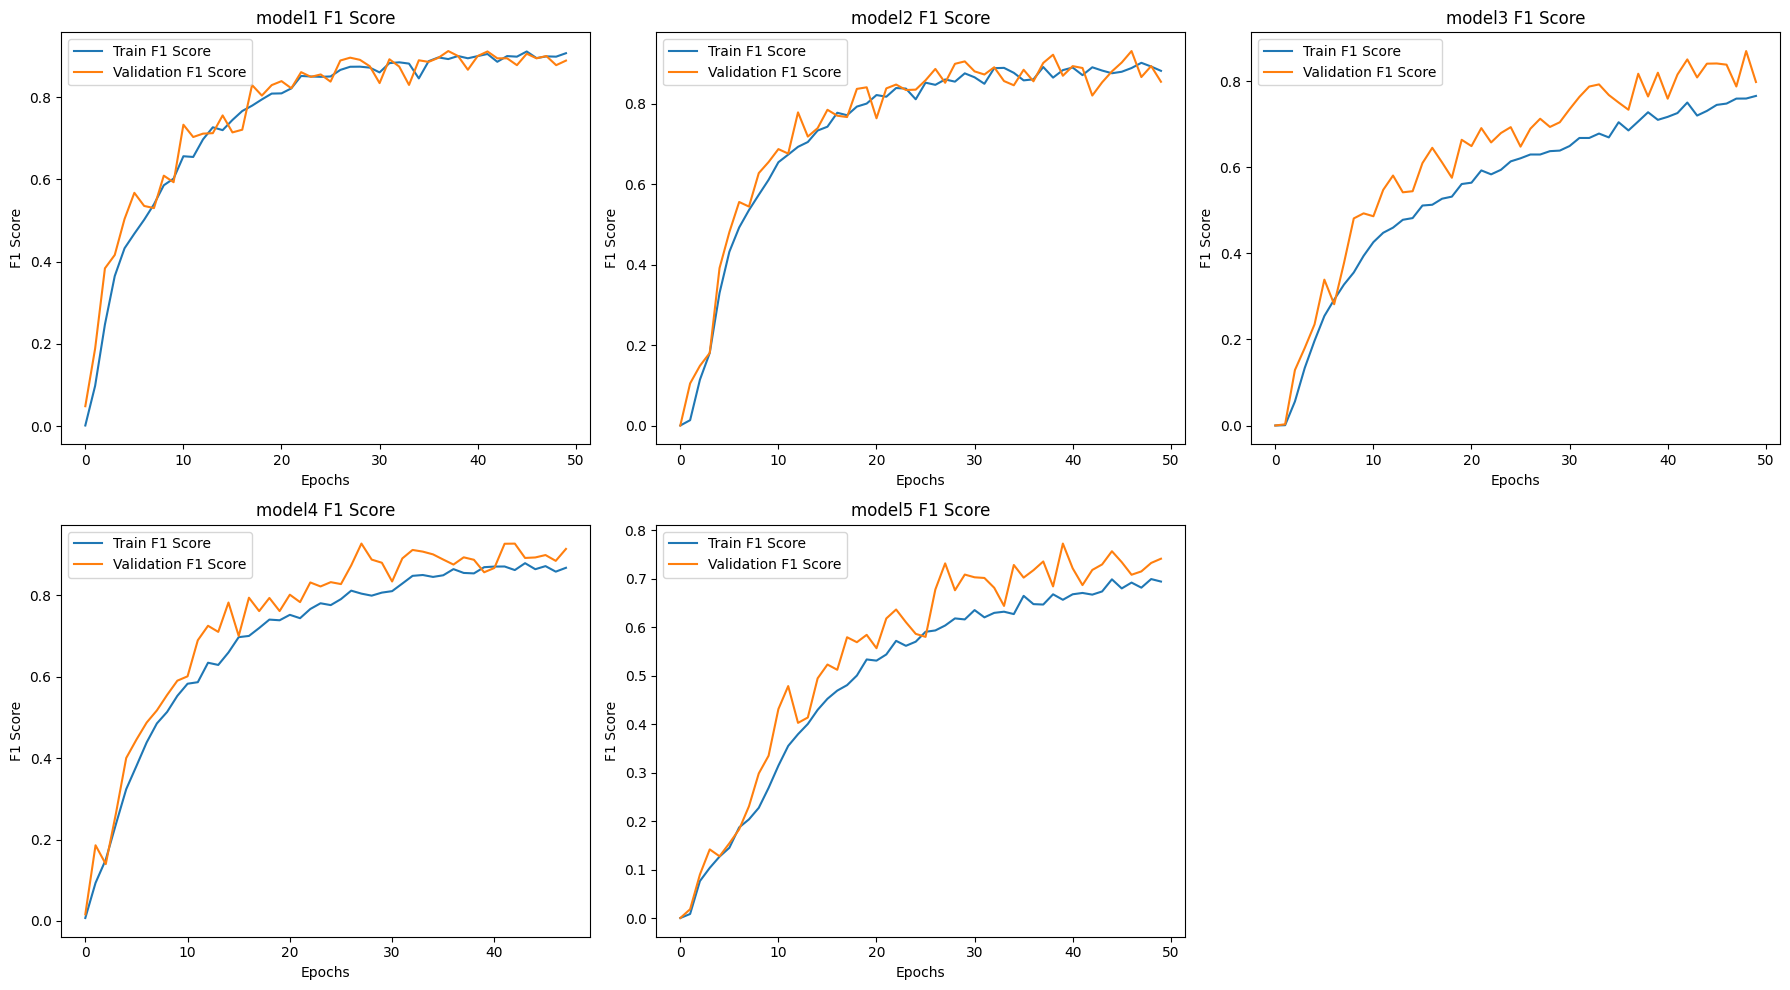

In [69]:
plt.figure(figsize=(18, 10))  # Adjust figure size for three rows
for idx, (model_name, history) in enumerate(model_histories.items()):
    # Subplot for F1 Score
    plt.subplot(2, 3, idx + 1)
    plt.plot(history.history['f1_score'], label=f'Train F1 Score')
    plt.plot(history.history['val_f1_score'], label=f'Validation F1 Score')
    plt.title(f'{model_name} F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

plt.tight_layout()
plt.show()


According to the figures ;  all models are performing well regarding the preprocessing stages. However, as the architectures become more complex, performance tends to decrease. Nevertheless, the performance remains satisfactory, indicating that the increased complexity allows the model to learn more features, which is beneficial for long-term performance

In [70]:
df_running_time = pd.DataFrame(list(training_time.items()), columns=['Model', 'Training Time (seconds)'])
df_running_time

Model  Training Time (seconds)
0  model1                40.357806
1  model2                60.345886
2  model3                42.515442
3  model4                67.904828
4  model5                63.521001

Models 1 and 4 require the most training time, taking nearly a minute each.

However, overall, the training times remain reasonable.

## Final Model

We have chosen model 4 from the 5 models available, due to its complexity and consistent results on the training, validation, and test data.

let's look at the confusion matrix

In [71]:
# Here we would get the output as probablities for each category
y_pred=model4.predict(test_dataset)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


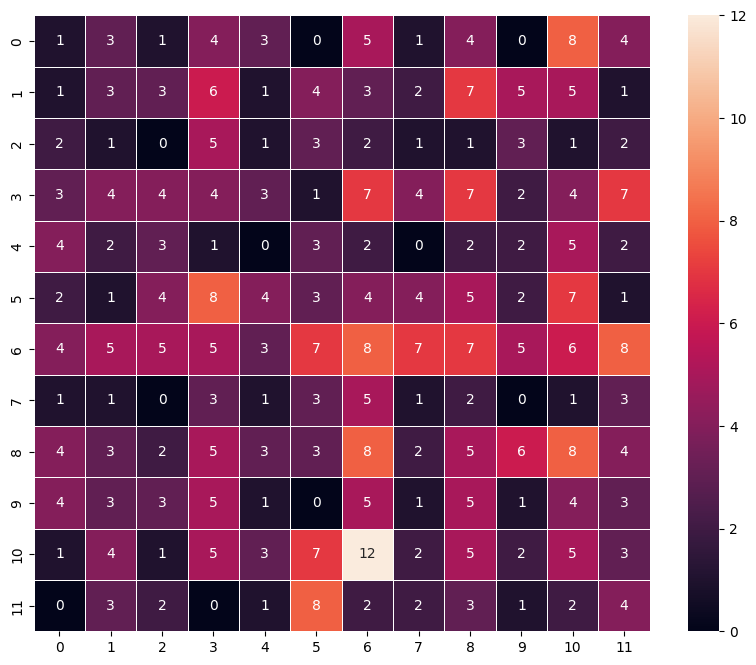

In [72]:
# Obtain the true labels from the test dataset
y_test_all = []
for images, labels in test_dataset:
    y_test_all.append(labels.numpy())

# Convert list of label batches to a single array
y_test_all = np.concatenate(y_test_all, axis=0)

# Convert one-hot encoded labels to categorical values
y_test_arg = np.argmax(y_test_all, axis=1)
# convert y_pred to categorical values
y_pred_arg = np.argmax(y_pred, axis=1)

# Compute confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Plot confusion matrix
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [73]:
y_pred5=model5.predict(test_dataset)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


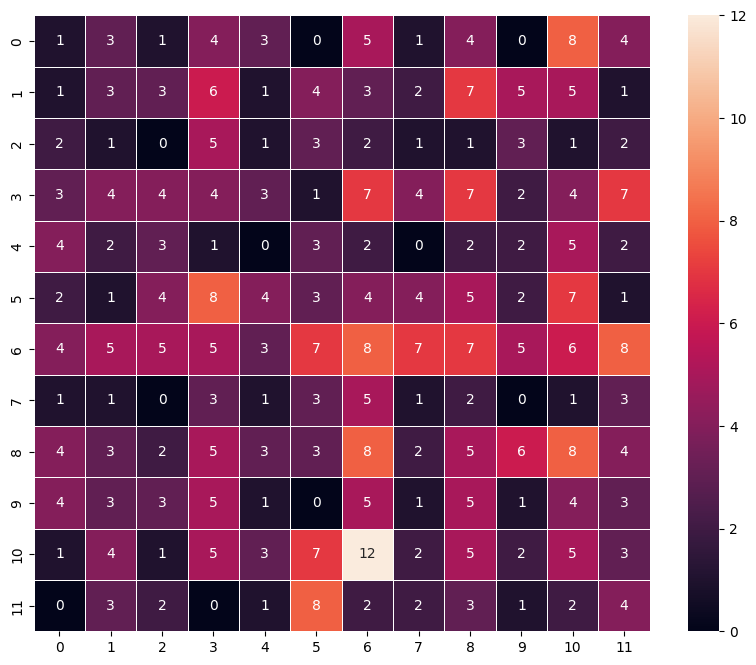

In [74]:
# convert y_pred to categorical values
y_pred_arg5 = np.argmax(y_pred5, axis=1)

# Compute confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Plot confusion matrix
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

I'm not happy with this result but needs more improvements .  we're experiencing a discrepancy between the performance metrics and the confusion matrix. While our metrics (like accuracy, los, f1score) may indicate good performance, the confusion matrix reveals the true nature of misclassifications across different classes.

### Visualizing the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


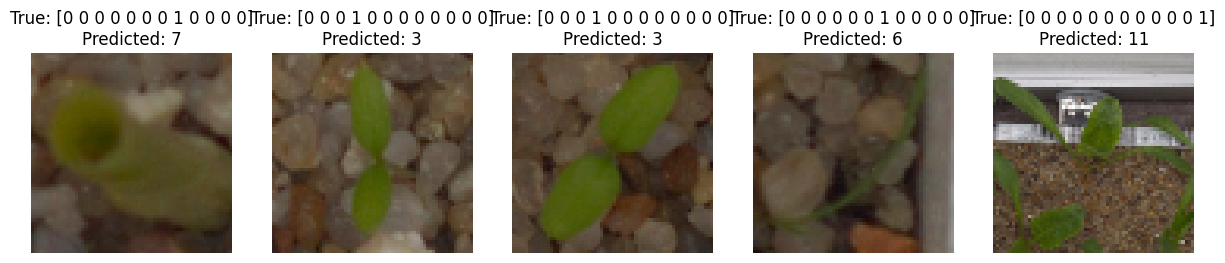

In [75]:
def plot_predictions(model, dataset, num_images=5):
    """
    Visualizes a sample of predictions by showing the images along with predicted and actual labels.

    :param model: The trained model.
    :param dataset: The dataset containing images and labels (validation or test).
    :param num_images: Number of images to display.
    """
    # Get a batch of images and labels from the dataset
    for images, labels in dataset.take(1):
        predictions = model.predict(images)

        # Get predicted class indices
        predicted_indices = np.argmax(predictions, axis=1)

        # Convert labels to numpy array if not already
        labels_np = labels.numpy().astype(int)  # Ensure labels are integers

        # Plot the images with true and predicted labels (numeric)
        plt.figure(figsize=(15, 8))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # Adjust cmap if needed
            plt.title(f"True: {labels_np[i]}\nPredicted: {predicted_indices[i]}")
            plt.axis('off')

        plt.show()


plot_predictions(model4, test_dataset, num_images=5)


## Actionable Insights and Business Recommendations

###  Summary

From what I’ve gathered, I built a CNN model to classify plant seedlings, reducing the image size to 64x64 for efficiency. The main challenge I faced is that the seedlings, despite varying leaf shapes, have a lot of visual similarities (green leaves), which complicates classification. The dataset also has imbalanced labels, which impacts the model’s ability to learn well across all classes.

Interestingly, my initial, simpler model performed better than more complex ones with additional layers and regularization techniques like batch normalization and dropout. Even though metrics like accuracy and loss looked good on the surface, the confusion matrix showed some substantial misclassifications. This discrepancy suggests the model struggles with specific classes despite high overall performance.

### Actionable Insights

- **Model Complexity**: I've seen that adding layers and complexity didn't help as much as expected. I should stick to simpler architectures for now. This avoids overfitting and keeps training times manageable. My first model seems to offer the right balance between simplicity and effectiveness.

- **Label Imbalance**: The imbalanced dataset is definitely a factor here. I should use strategies like oversampling the underrepresented classes or adding class weights in the loss function during training. This will help the model focus more on the minority classes and reduce misclassifications.

- **Augmentation Impact**: The data augmentation I tried didn't improve the results as much as I hoped. Given the uniformity in color across classes (all plants are green), I might shift to augmentations that vary the leaf shapes or plant orientations more drastically. It seems the model would benefit more from diverse shapes rather than brightness or color changes.

- **Confusion Matrix Analysis**: Although I'm seeing good accuracy and low loss, the confusion matrix tells a different story. There are significant misclassifications between some classes. I should dig into which specific classes are causing the most trouble and why. Using metrics like per-class accuracy or the F1 score might give a clearer picture than just relying on overall accuracy.

- **Generalization**: I noticed the fourth model, with callback, dropout, and batch normalization, generalizes well on unseen data. So, while keeping regularization methods like dropout is important, adding complexity doesn't always help. Sticking to regularization without unnecessary architectural changes might be the best move.

### Business Recommendations

- **Simplify the Architecture**: I should stick with the simpler architecture that has already performed well. I'm getting great results with fewer layers, and adding complexity isn't necessary for this task. It will also keep training time down.

- **Focus on Misclassifications**: The confusion matrix suggests some classes are more problematic than others. I should zero in on those. Analyzing feature importance and refining how the model distinguishes between similar classes like certain seedlings might help.

- **Handle the Imbalanced Dataset**: I'll implement techniques for rebalancing my dataset or adjusting class weights. This will make my model more reliable and less prone to overfitting on dominant classes.

- **Improve Augmentation**: I should revamp the augmentation strategy. It seems like the model isn't benefiting from current transformations. I'll focus on transformations that directly relate to the variations between classes, such as rotations, zooming, or stretching, instead of altering brightness or color.

- **Monitor and Refine**: I'll keep monitoring the performance with more test data and watch the confusion matrix closely. This will help ensure that the high accuracy numbers aren't hiding critical misclassifications. Fine-tuning based on these insights should help me avoid long-term issues.

_____